In [1]:
import os
import re
import math
import time
import jieba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import word2vec
from gensim import models
from langconv import *

%matplotlib inline
pd.options.display.max_columns = None
plt.rcParams['font.sans-serif']=['SimHei']

In [9]:
cws_model = r'D:\GitHub\Pyltp\ltp_data\cws.model'

from pyltp import Segmentor
segmentor = Segmentor()
segmentor.load(cws_model)
words = segmentor.segment('其次，这样的花卉一如远嫁它乡的女子，离别了故园来到异地，若不能以日夜牵念之情而把守，寒暑不忘之心而敬爱，却希翼它日日保持婀娜纤巧之美貌，婆娑盘旋之旖丽，如何才是可以呢？')
print([i for i in words])
segmentor.release()

['其次', '，', '这样', '的', '花卉', '一', '如', '远', '嫁', '它', '乡', '的', '女子', '，', '离别', '了', '故园', '来到', '异地', '，', '若', '不', '能', '以', '日夜', '牵念', '之', '情', '而', '把守', '，', '寒暑', '不', '忘', '之', '心', '而', '敬爱', '，', '却', '希翼', '它', '日日', '保持', '婀娜', '纤巧', '之', '美貌', '，', '婆娑', '盘旋', '之', '旖丽', '，', '如何', '才', '是', '可以', '呢', '？']


In [10]:
print([i for i in jieba.cut('其次，这样的花卉一如远嫁它乡的女子，离别了故园来到异地，若不能以日夜牵念之情而把守，寒暑不忘之心而敬爱，却希翼它日日保持婀娜纤巧之美貌，婆娑盘旋之旖丽，如何才是可以呢？')])

['其次', '，', '这样', '的', '花卉', '一如', '远嫁', '它', '乡', '的', '女子', '，', '离别', '了', '故园', '来到', '异地', '，', '若', '不能', '以', '日夜', '牵念', '之情', '而', '把守', '，', '寒暑', '不忘之心', '而', '敬爱', '，', '却', '希翼', '它', '日日', '保持', '婀娜', '纤巧', '之', '美貌', '，', '婆娑', '盘旋', '之旖丽', '，', '如何', '才', '是', '可以', '呢', '？']


In [11]:
import pkuseg

seg = pkuseg.pkuseg()
text = seg.cut('其次，这样的花卉一如远嫁它乡的女子，离别了故园来到异地，若不能以日夜牵念之情而把守，寒暑不忘之心而敬爱，却希翼它日日保持婀娜纤巧之美貌，婆娑盘旋之旖丽，如何才是可以呢？')
print(text)

['其次', '，', '这样', '的', '花卉', '一如', '远嫁', '它', '乡', '的', '女子', '，', '离别', '了', '故园', '来到', '异地', '，', '若', '不', '能', '以', '日夜', '牵念', '之', '情', '而', '把守', '，', '寒暑', '不', '忘', '之', '心', '而', '敬爱', '，', '却', '希翼', '它', '日日', '保持', '婀娜', '纤巧', '之', '美貌', '，', '婆娑', '盘旋', '之', '旖丽', '，', '如何', '才', '是', '可以', '呢', '？']


In [2]:
train = pd.read_csv("sentiment_analysis_trainingset.csv")
validation = pd.read_csv("sentiment_analysis_validationset.csv")
print(train.info())
print(validation.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 22 columns):
id                                          105000 non-null int64
content                                     105000 non-null object
location_traffic_convenience                105000 non-null int64
location_distance_from_business_district    105000 non-null int64
location_easy_to_find                       105000 non-null int64
service_wait_time                           105000 non-null int64
service_waiters_attitude                    105000 non-null int64
service_parking_convenience                 105000 non-null int64
service_serving_speed                       105000 non-null int64
price_level                                 105000 non-null int64
price_cost_effective                        105000 non-null int64
price_discount                              105000 non-null int64
environment_decoration                      105000 non-null int64
environment_noise             

In [4]:
train.head(1)

,id,content,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,price_discount,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
0,0,"""吼吼吼，萌死人的棒棒糖，中了大众点评的霸王餐，太可爱了。一直就好奇这个棒棒糖是怎么个东西，...",-2,-2,-2,-2,1,-2,-2,-2,-2,1,-2,-2,-2,-2,-2,-2,1,-2,1,-2


In [18]:
train['content'][0]

'"吼吼吼，萌死人的棒棒糖，中了大众点评的霸王餐，太可爱了。一直就好奇这个棒棒糖是怎么个东西，大众点评给了我这个土老冒一个见识的机会。看介绍棒棒糖是用德国糖做的，不会很甜，中间的照片是糯米的，能食用，真是太高端大气上档次了，还可以买蝴蝶结扎口，送人可以买礼盒。我是先打的卖家电话，加了微信，给卖家传的照片。等了几天，卖家就告诉我可以取货了，去大官屯那取的。虽然连卖家的面都没见到，但是还是谢谢卖家送我这么可爱的东西，太喜欢了，这哪舍得吃啊。"'

In [19]:
validation.head(1)

,id,content,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,price_discount,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
0,0,"""哎，想当年来佘山的时候，啥都没有，三品香算镇上最大看起来最像样的饭店了。菜品多，有点太多，...",-2,-2,-2,0,-2,-2,-2,1,-2,-2,-2,-2,-2,-2,-2,0,-2,-2,1,0


In [20]:
validation['content'][0]

'"哎，想当年来佘山的时候，啥都没有，三品香算镇上最大看起来最像样的饭店了。菜品多，有点太多，感觉啥都有，杂都不足以形容。随便点些，居然口味什么的都好还可以，价钱自然是便宜当震惊。元宝虾和椒盐九肚鱼都不错吃。不过近来几次么，味道明显没以前好了。冷餐里面一个凉拌海带丝还可以，酸酸甜甜的。镇上也有了些别的大点的饭店，所以不是每次必来了。对了，这家的生意一如既往的超级好，不定位基本吃不到。不过佘山这边的人吃晚饭很早的，所以稍微晚点去就很空了。"'

In [21]:
validation.location_traffic_convenience.value_counts()

-2    11757
 1     2925
-1      182
 0      136
Name: location_traffic_convenience, dtype: int64

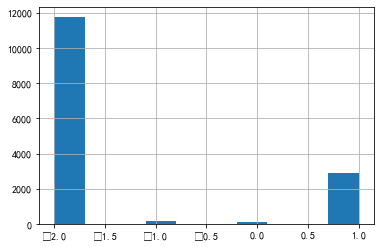

In [23]:
validation.location_traffic_convenience.hist()

In [12]:
#get the stop words
file = r'.\zh_stopwords.txt'
def get_stopwords(path):
    stop_words = []
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            stop_words.append(line.strip())
    return stop_words
stop_words = get_stopwords(file)

In [13]:
stop_words[:15]

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”']

In [14]:
def trans2simp(line):
    line = Converter('zh-hans').convert(line)
    return line

In [15]:
trans2simp('我們吃饭去了，测试句子。')

'我们吃饭去了，测试句子。'

In [15]:
data = train.append(validation).reset_index(drop=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 22 columns):
id                                          120000 non-null int64
content                                     120000 non-null object
location_traffic_convenience                120000 non-null int64
location_distance_from_business_district    120000 non-null int64
location_easy_to_find                       120000 non-null int64
service_wait_time                           120000 non-null int64
service_waiters_attitude                    120000 non-null int64
service_parking_convenience                 120000 non-null int64
service_serving_speed                       120000 non-null int64
price_level                                 120000 non-null int64
price_cost_effective                        120000 non-null int64
price_discount                              120000 non-null int64
environment_decoration                      120000 non-null int64
environment_noise             

In [17]:
data.head(1)

,id,content,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,price_discount,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
0,0,"""吼吼吼，萌死人的棒棒糖，中了大众点评的霸王餐，太可爱了。一直就好奇这个棒棒糖是怎么个东西，...",-2,-2,-2,-2,1,-2,-2,-2,-2,1,-2,-2,-2,-2,-2,-2,1,-2,1,-2


In [18]:
def cut(string):
    '''
    # remove stop_words seems to be not very well
    string = trans2simp(string)
    w_list = jieba.cut(string)
    nw_list = []
    
    for w in w_list:
        if w not in stop_words:
            nw_list.append(w)
    return ' '.join(w for w in nw_list)
    '''
    string = trans2simp(string).replace('\n', '')
    w_list = jieba.cut(string)
    return ' '.join(w for w in w_list)

In [19]:
cut(data['content'][1])

Building prefix dict from the default dictionary ...


11/24/2019 02:10:13 - DEBUG - jieba -   Building prefix dict from the default dictionary ...


Loading model from cache C:\Users\Dracu\AppData\Local\Temp\jieba.cache


11/24/2019 02:10:13 - DEBUG - jieba -   Loading model from cache C:\Users\Dracu\AppData\Local\Temp\jieba.cache


Loading model cost 0.621 seconds.


11/24/2019 02:10:14 - DEBUG - jieba -   Loading model cost 0.621 seconds.


Prefix dict has been built succesfully.


11/24/2019 02:10:14 - DEBUG - jieba -   Prefix dict has been built succesfully.


'" 第三次 参加 大众 点评 网 霸王餐 的 活动 。 这家 店 给 人 整体 感觉 一般 。 首先 环境 只能 算 中等 ， 其次 霸王餐 提供 的 菜品 也 不是 很多 ， 当然 商家 为了 避免 参加 霸王餐 吃不饱 的 现象 ， 给 每桌 都 提供 了 至少 六份 主食 ， 我们 那桌 都 提供 了 两份 年糕 ， 第一次 吃火锅 会 在 桌上 有 这么 多 的 主食 了 。 整体 来说 这家 火锅店 没有 什么 特别 有 特色 的 ， 不过 每份 菜品 分量 还是 比较 足 的 ， 这点 要 肯定 ！ 至于 价格 ， 因为 没有 看 菜单 不 了解 ， 不过 我 看 大众 有 这家 店 的 团购 代金券 ， 相当于 7 折 ， 应该 价位 不会 很 高 的 ！ 最后 还是 要 感谢 商家 提供 霸王餐 ， 祝 生意兴隆 ， 财源 广进 "'

In [20]:
data['content'] = data['content'].apply(cut)

In [21]:
data.head(2)

,id,content,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,price_cost_effective,price_discount,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
0,0,""" 吼吼 吼 ， 萌死 人 的 棒棒糖 ， 中 了 大众 点评 的 霸王餐 ， 太 可爱 了...",-2,-2,-2,-2,1,-2,-2,-2,-2,1,-2,-2,-2,-2,-2,-2,1,-2,1,-2
1,1,""" 第三次 参加 大众 点评 网 霸王餐 的 活动 。 这家 店 给 人 整体 感觉 一般 ...",-2,-2,-2,-2,-2,-2,-2,0,-2,1,0,0,0,0,1,-2,-2,-2,1,-2


In [67]:
data['content'][:5]

0    " 吼吼 吼 ， 萌死 人 的 棒棒糖 ， 中 了 大众 点评 的 霸王餐 ， 太 可爱 了...
1    " 第三次 参加 大众 点评 网 霸王餐 的 活动 。 这家 店 给 人 整体 感觉 一般 ...
2    " 4 人 同行   点 了 10 个 小吃 榴莲 酥   榴莲 味道 不足   松软   ...
3    " 之前 评价 了 莫名其妙 被删   果断 继续 差评 ！   换 了 菜单   价格 更...
4    " 出乎意料 地 惊艳 ， 椰子 鸡 清热 降火 ， 美容 养颜 ， 大大 满足 了 爱 吃...
Name: content, dtype: object

In [7]:
data.to_csv(r'./data/train.csv', index=False, encoding='utf_8')
data[len(data)-1500:len(data)].to_csv(r'./data/val.csv', index=False, encoding='utf_8')

NameError: name 'data' is not defined

In [52]:
#Always use this
data = pd.read_csv('./data/train.csv')
label_cols = data.columns.values.tolist()[2:]

In [53]:
#Test small dataset
s_train = data[:2000].to_csv(r'./data/s_train.csv', index=False, encoding='utf_8')
s_valid = data[2000:2200].to_csv(r'./data/s_valid.csv', index=False, encoding='utf_8')

In [9]:
df = pd.DataFrame()
df['label'] = data.columns.values.tolist()[2:]

In [33]:
df.to_csv(r'./labels/labels.csv', header=False, index=False)

In [63]:
with open('corpus.txt', 'w', encoding='utf-8') as f:
    for i in range(len(data)):
        f.write(data['train_content'][i] + '\n')

In [67]:
sentences = word2vec.Text8Corpus("corpus.txt")
model = word2vec.Word2Vec(sentences, size=300, window=10, min_count=1, workers=5)

In [68]:
model.save("train.model")
#model_2 = word2vec.Word2Vec.load("text8.model")

In [12]:
import torch
import apex
from fastai.text import *
import datetime
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

In [33]:
args = {
    "run_text": "my_test",
    "max_seq_length": 256, #512
    "do_lower_case": True,
    "train_batch_size": 4, #16
    "learning_rate": 6e-5,
    "num_train_epochs": 12.0,
    "warmup_proportion": 0.002,
    "local_rank": -1,
    "gradient_accumulation_steps": 1,
    "fp16": False,
    "loss_scale": 32 #128
}

In [54]:
LOG_PATH = Path('logs/')  
MODEL_PATH = Path('models/') 

if not LOG_PATH.exists():
    LOG_PATH.mkdir()
import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

device = torch.device('cuda')

if torch.cuda.device_count() > 1:
    multi_gpu = True
else:
    multi_gpu = False

In [55]:
from fast_bert.data_cls import BertDataBunch
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy_multilabel
from pytorch_pretrained_bert.tokenization import BertTokenizer

In [56]:
DATA_PATH = Path(r'./data/')     
LABEL_PATH = Path(r'./labels/')  

BERT_PRETRAINED_PATH = Path(r'./chinese_L-12_H-768_A-12/')
#BERT_PRETRAINED_PATH = 'bert-base-chinese'

In [57]:
#tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_PATH, do_lower_case=args['do_lower_case'])

In [58]:
# create DataBunch object
databunch = BertDataBunch(DATA_PATH, LABEL_PATH, 
                          tokenizer='bert-base-chinese', 
                          train_file='s_train.csv', 
                          val_file='s_valid.csv', 
                          label_file='labels.csv',
                          text_col='content',
                          label_col=label_cols,
                          batch_size_per_gpu=args['train_batch_size'], 
                          max_seq_length=args['max_seq_length'], 
                          multi_gpu=multi_gpu, 
                          multi_label=True,
                          model_type='bert'
                         )

11/28/2019 22:23:40 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt from cache at C:\Users\Dracu\.cache\torch\transformers\8a0c070123c1f794c42a29c6904beb7c1b8715741e235bee04aca2c7636fc83f.9b42061518a39ca00b8b52059fd2bede8daa613f8a8671500e518a8c29de8c00
11/28/2019 22:23:40 - INFO - root -   Loading features from cached file data\cache\cached_bert_train_multi_label_256
11/28/2019 22:23:40 - INFO - root -   Loading features from cached file data\cache\cached_bert_dev_multi_label_256


In [41]:
metrics = [{'name': 'accuracy_multilabel', 'function': accuracy_multilabel}]

In [42]:
logger.info(args)

11/28/2019 21:23:43 - INFO - root -   {'run_text': 'my_test', 'max_seq_length': 256, 'do_lower_case': True, 'train_batch_size': 4, 'learning_rate': 6e-05, 'num_train_epochs': 12.0, 'warmup_proportion': 0.002, 'local_rank': -1, 'gradient_accumulation_steps': 1, 'fp16': False, 'loss_scale': 32}


In [59]:
# create a Learner object
learner = BertLearner.from_pretrained_model(databunch,
                                            pretrained_path=BERT_PRETRAINED_PATH,
                                            metrics=metrics,
                                            device=device,
                                            logger=logger,
                                            output_dir=MODEL_PATH,
                                            finetuned_wgts_path=None,
                                            warmup_steps=500,
                                            multi_gpu=multi_gpu,
                                            is_fp16=args['fp16'],
                                            loss_scale=args['loss_scale'],
                                            multi_label=True,
                                            logging_steps=50)

11/28/2019 22:23:52 - INFO - transformers.configuration_utils -   loading configuration file chinese_L-12_H-768_A-12\config.json
11/28/2019 22:23:52 - INFO - transformers.configuration_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 20,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 21128
}

11/28/2019 22:23:52 - INFO - transformers.modeling_utils

In [60]:
# train the model
learner.fit(epochs=6,
            lr=args['learning_rate'],
            validate=True,
            schedule_type="warmup_cosine",
            optimizer_type="lamb")

models\tensorboard
11/28/2019 22:24:11 - INFO - root -   ***** Running training *****
11/28/2019 22:24:11 - INFO - root -     Num examples = 400
11/28/2019 22:24:11 - INFO - root -     Num Epochs = 6
11/28/2019 22:24:11 - INFO - root -     Total train batch size (w. parallel, distributed & accumulation) = 4
11/28/2019 22:24:11 - INFO - root -     Gradient Accumulation steps = 1
11/28/2019 22:24:11 - INFO - root -     Total optimization steps = 600


RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 6.00 GiB total capacity; 4.60 GiB already allocated; 11.14 MiB free; 114.13 MiB cached)

In [45]:
learner.predict_batch(['吼吼吼，萌死人的棒棒糖，中了大众点评的霸王餐，太可爱了。一直就好奇这个棒棒糖是怎么个东西，大众点评给了我这个土老冒一个见识的机会。看介绍棒棒糖是用德国糖做的，不会很甜，中间的照片是糯米的，能食用，真是太高端大气上档次了，还可以买蝴蝶结扎口，送人可以买礼盒。我是先打的卖家电话，加了微信，给卖家传的照片。等了几天，卖家就告诉我可以取货了，去大官屯那取的。虽然连卖家的面都没见到，但是还是谢谢卖家送我这么可爱的东西，太喜欢了，这哪舍得吃啊。'])

11/28/2019 21:43:10 - INFO - root -   Writing example 0 of 1
11/28/2019 21:43:10 - INFO - root -   Saving features into cached file data\cache\cached_bert_test_multi_label_256


[[('others_overall_experience', 0.6227706074714661),
  ('dish_taste', 0.46760639548301697),
  ('service_waiters_attitude', 0.3008595407009125),
  ('dish_portion', 0.2891949415206909),
  ('environment_noise', 0.26900535821914673),
  ('location_easy_to_find', 0.2471245676279068),
  ('others_willing_to_consume_again', 0.23873268067836761),
  ('environment_cleaness', 0.23855119943618774),
  ('price_discount', 0.22974546253681183),
  ('location_distance_from_business_district', 0.22523802518844604),
  ('environment_decoration', 0.22421284019947052),
  ('location_traffic_convenience', 0.19162552058696747),
  ('service_serving_speed', 0.19049598276615143),
  ('environment_space', 0.18446438014507294),
  ('price_level', 0.1692456156015396),
  ('service_wait_time', 0.158110111951828),
  ('dish_look', 0.15700635313987732),
  ('price_cost_effective', 0.1169365867972374),
  ('service_parking_convenience', 0.10419387370347977),
  ('dish_recommendation', 0.0947360023856163)]]